# Sub-graph sample

In [1]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "0.36.2";
var langgraph4jVersion = "1.1-SNAPSHOT";

In [2]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos

Repository local url: file:///Users/bsorrentino/.m2/repository/ added.


In [3]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

In [4]:
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core-jdk8:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8

%dependency /resolve

Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core-jdk8:1.1-SNAPSHOT
Adding dependency org.bsc.langgraph4j:langgraph4j-langchain4j:1.1-SNAPSHOT
Adding dependency dev.langchain4j:langchain4j:0.36.2
Adding dependency dev.langchain4j:langchain4j-open-ai:0.36.2
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Resolved artifacts count: 27
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-jdk14/2.0.9/slf4j-jdk14-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-api/2.0.9/slf4j-api-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core-jdk8/1.1-SNAPSHOT/langgraph4j-core-jdk8-1.1-SNAPSHOT.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/asy

In [5]:
import org.bsc.langgraph4j.state.AgentState;
import org.bsc.langgraph4j.state.Channel;
import org.bsc.langgraph4j.state.AppenderChannel;

public class State extends AgentState {

    static Map<String, Channel<?>> SCHEMA = Map.of(
            "messages", AppenderChannel.<String>of(ArrayList::new)
    );

    public State(Map<String, Object> initData) {
        super( initData  );
    }

    List<String> messages() { return this.<List<String>>value("messages").get(); } 
    
}


In [6]:
import org.bsc.langgraph4j.StateGraph;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;


AsyncNodeAction<State> childStep1 = node_async(state -> Map.of( "messages", "child:step1") );

AsyncNodeAction<State> childStep2 = node_async(state -> Map.of( "messages", "child:step2") );

AsyncNodeAction<State> childStep3 = node_async(state -> Map.of( "messages", "child:step3") );


var workflowChild = new StateGraph<>(State.SCHEMA, State::new)        
                    .addNode("child:step_1", childStep1)
                    .addNode("child:step_2", childStep2)
                    .addNode("child:step_3", childStep3)
                    .addEdge(START, "child:step_1")
                    .addEdge("child:step_1", "child:step_2")
                    .addEdge("child:step_2", "child:step_3")
                    .addEdge("child:step_3", END)
                    .compile();

for( var step : workflowChild.stream( Map.of() ) ) {
    System.out.println( step );
}

NodeOutput{node=__START__, state={messages=[]}}
NodeOutput{node=child:step_1, state={messages=[child:step1]}}
NodeOutput{node=child:step_2, state={messages=[child:step1, child:step2]}}
NodeOutput{node=child:step_3, state={messages=[child:step1, child:step2, child:step3]}}
NodeOutput{node=__END__, state={messages=[child:step1, child:step2, child:step3]}}


In [7]:

AsyncNodeAction<State> step1 = node_async(state -> Map.of( "messages", "step1") );

AsyncNodeAction<State> step2 = node_async(state -> Map.of( "messages", "step2") );

AsyncNodeAction<State> step3 = node_async(state -> Map.of( "messages", "step3") );


var workflowParent = new StateGraph<>(State.SCHEMA, State::new)        
                    .addNode("step_1", step1)
                    .addNode("step_2", step2)
                    .addNode("step_3", step3)
                    .addSubgraph( "subgraph", workflowChild )
                    .addEdge(START, "step_1")
                    .addEdge("step_1", "step_2")
                    .addEdge("step_2", "subgraph")
                    .addEdge("subgraph", "step_3")
                    .addEdge("step_3", END)
                    .compile();

for( var step : workflowParent.stream( Map.of() )) {
    System.out.println( step );
}

NodeOutput{node=__START__, state={messages=[]}}
NodeOutput{node=step_1, state={messages=[step1]}}
NodeOutput{node=step_2, state={messages=[step1, step2]}}
NodeOutput{node=__START__, state={messages=[step1, step2]}}
NodeOutput{node=child:step_1, state={messages=[step1, step2, child:step1]}}
NodeOutput{node=child:step_2, state={messages=[step1, step2, child:step1, child:step2]}}
NodeOutput{node=child:step_3, state={messages=[step1, step2, child:step1, child:step2, child:step3]}}
NodeOutput{node=__END__, state={messages=[step1, step2, child:step1, child:step2, child:step3]}}
NodeOutput{node=subgraph, state={messages=[step1, step2]}}
NodeOutput{node=step_3, state={messages=[step1, step2, step3]}}
NodeOutput{node=__END__, state={messages=[step1, step2, step3]}}


In [8]:
import org.bsc.langgraph4j.GraphRepresentation;

var representation = workflowParent.getGraph( GraphRepresentation.Type.PLANTUML, "sub graph",false );

representation.getContent()


@startuml sub_graph
skinparam usecaseFontSize 14
skinparam usecaseStereotypeFontSize 12
skinparam hexagonFontSize 14
skinparam hexagonStereotypeFontSize 12
title "sub graph"
footer

powered by langgraph4j
end footer
circle start<<input>> as __START__
circle stop as __END__
usecase "step_1"<<Node>>
usecase "step_2"<<Node>>
usecase "step_3"<<Node>>
rectangle subgraph [ {{
title "subgraph"
circle " " as __START__
circle exit as __END__
usecase "child:step_1"<<Node>>
usecase "child:step_2"<<Node>>
usecase "child:step_3"<<Node>>
"__START__" -down-> "child:step_1"
"child:step_1" -down-> "child:step_2"
"child:step_2" -down-> "child:step_3"
"child:step_3" -down-> "__END__"

}} ]
"__START__" -down-> "step_1"
"step_1" -down-> "step_2"
"step_2" -down-> "subgraph"
"subgraph" -down-> "step_3"
"step_3" -down-> "__END__"
@enduml


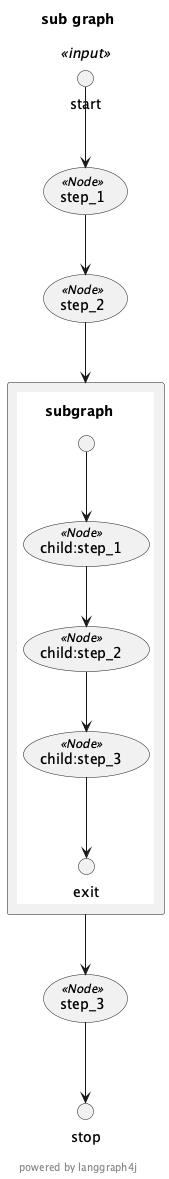

36c25493-4f90-4388-aee5-54285354fff1

In [9]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;

java.awt.Image plantUML2PNG( String code ) throws IOException { 
    var reader = new SourceStringReader(code);

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        return javax.imageio.ImageIO.read( imageInStream );

    }
}

display( plantUML2PNG( representation.getContent() ) )